# Обучение предиктивной модели

In [1]:
## Загрузка необходимых библиотек
import pandas as pd
from pandas import MultiIndex
import numpy as np
import glob
import datetime
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from catboost import CatBoostRegressor, Pool, cv
import xgboost as xgb

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 1. Подготовка учебного датасета

In [3]:
## Чтение данных из файла
weather = pd.read_csv('DATA/weather_data_total4.csv.gz', compression='gzip', header=0, sep=';'
                      , quotechar='"')
settl = pd.read_csv('DATA/Settlement_Id.zip', compression='zip', header=0, sep=';'
                    , dtype={'digit_id': 'object'}, quotechar='"')
target = pd.read_csv('INPUT/target.csv.zip', compression='zip', header=0, sep=';', decimal=','
                     , dtype={'digit_id': 'object'}, quotechar='"')
municip = pd.read_csv('INPUT/id_муниципалитета.csv.zip', compression='zip', header=0, sep=';'
                      , dtype={'digit_id': 'object'}, quotechar='"')
diff_trend = pd.read_csv('DATA/data_ssa.csv.gz', compression='gzip', header=0, sep=';'
                         , dtype={'yield_code': 'object'}, quotechar='"')

In [4]:
## Добавление id метеостанций к фрейму с целевой переменной
# добавление данных по урожайности и накопленного тренда урожайности
target = target[['digit_id', 'year', 'category', 'yield']]
target['triplet'] = target['digit_id'].astype(str).str[:3]
target['solo'] = target['digit_id'].astype(str).str[0]+'00'
diff_trend = diff_trend.loc[pd.notnull(diff_trend['diff_cumulative']), ['year', 'yield_code', 'diff_cumulative']]
# создание массива по урожайности
target = pd.merge(target, diff_trend, how='left', left_on=['year', 'triplet'], right_on=['year', 'yield_code'])
target = pd.merge(target, diff_trend, how='left', left_on=['year', 'solo'], right_on=['year', 'yield_code'])

# очистка урожайности от тренда
target['trendless'] = np.nan
target.loc[pd.isnull(target['trendless']), 'trendless'] = target.loc[pd.isnull(target['trendless']), 'yield'] - target.loc[pd.isnull(target['trendless']), 'diff_cumulative_x']
target.loc[pd.isnull(target['trendless']), 'trendless'] = target.loc[pd.isnull(target['trendless']), 'yield'] - target.loc[pd.isnull(target['trendless']), 'diff_cumulative_y']
target.dropna(subset=['trendless'], inplace=True)
target = target[['digit_id', 'year', 'category', 'trendless']]

# добавление данных по метеостанциям
meteo = settl[['digit_id', 'meteoid']].drop_duplicates()
target = pd.merge(target, meteo, how='left', on=['digit_id'])

# добавление данных с идентификаторами муниципалитетов
target = pd.merge(target, municip, how='left', on=['digit_id'])
target.drop_duplicates(keep='first', inplace=True, ignore_index=True) # удаление дубликатов

In [5]:
target.tail()

,digit_id,year,category,trendless,meteoid,id_municip,federal,region
48325,37701624,2021,Хозяйства всех категорий,-0.296245,28302,51015.0,Приволжский федеральный округ,Удмуртская республика
48326,37701624,2021,Хозяйства всех категорий,-0.296245,28411,51015.0,Приволжский федеральный округ,Удмуртская республика
48327,37701883,2021,Хозяйства всех категорий,-0.296245,28409,51007.0,Приволжский федеральный округ,Удмуртская республика
48328,37701883,2021,Хозяйства всех категорий,-0.296245,28411,51007.0,Приволжский федеральный округ,Удмуртская республика
48329,37700620,2021,Хозяйства всех категорий,-0.296245,28411,51010.0,Приволжский федеральный округ,Удмуртская республика


In [6]:
## Создание учебного датафрейма
target['region_id'] = target['digit_id'].astype(str).str[:3] # добавление id по региону
target.drop(columns=['digit_id', 'federal', 'region'], inplace=True)
data = pd.merge(weather, target, how='right', on=['year', 'meteoid'])
data.drop_duplicates(keep='first', inplace=True, ignore_index=True)
data.dropna(axis=0, how='any', inplace=True)
data['region_id'] = data['region_id'].astype(int)
data.rename(columns={"trendless": "target"}, inplace=True)

In [7]:
## Список неинформативных столбцов
antitop = [
    'min_baric_tendency',
    'min_u_humidity',
    'max_baric_tendency',
    'max_wind_speed',
    'max_wind_gust_between',
    'diff_cloudiness',
    'max_height_clouds',
    'diff_height_clouds',
    'min_cloudiness',
    'min_height_clouds',
    'min_wind_speed'
]

In [8]:
## Удаление неинформативных столбцов из датафрейма total
# создание списка неинформативных столбцов
drop_col_tot = []

for items in antitop:
    c = 'total_{}'.format(items)
    drop_col_tot.append(c)

data.drop(columns=drop_col_tot, inplace=True)

In [ ]:
## Удаление неинформативных столбцов датафрейма phase
# создание списка неинформативных столбцов
drop_col_ph = []

for phase in range(1,5):
    for items in antitop:
        c = 'ph{}_{}'.format(phase, items)
        drop_col_ph.append(c)
        
# удаление столбцов
data.drop(columns=drop_col_ph, inplace=True)

In [9]:
data = data.loc[(data['category'] !='КФХ')]
## Преобразование категориальных переменных признака "category" в числовые значения
le = LabelEncoder() # метод преобразования категориальных признаков
# преобразование в числовые значения
data['category'] = le.fit_transform(data['category'])

In [10]:
## Удаление лишних данных
del settl
del meteo
del weather

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31034 entries, 13365 to 48310
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          31034 non-null  float64
 1   meteoid                       31034 non-null  int64  
 2   total_min_air_temp            31034 non-null  float64
 3   total_min_ground_temp         31034 non-null  float64
 4   total_min_po_press            31034 non-null  float64
 5   total_max_air_temp            31034 non-null  float64
 6   total_max_po_press            31034 non-null  float64
 7   total_max_u_humidity          31034 non-null  float64
 8   total_max_cloudiness          31034 non-null  float64
 9   total_avg_air_temp            31034 non-null  float64
 10  total_avg_po_press            31034 non-null  float64
 11  total_avg_baric_tendency      31034 non-null  float64
 12  total_wind_rumb_radians       31034 non-null  float64
 1

## 2. Обучение моделей

### 2.1 Обучение моделей по регионам

In [12]:
## Инициализация модели
cat = CatBoostRegressor(iterations=3000, loss_function='RMSE')
reg_learn = []

## Обучение модели по регионам
for r in list(data['region_id'].unique()):
    reg_iter = []
    reg_iter.append(r)
    # ОБУЧЕНИЕ И ТЕСТОВАЯ ЧАСТЬ
    try:
        # Разбиение данных на train и test
        train = data.loc[(data['year'] != 2021) & (data['region_id'] == r)]
        train_label = train['target']
        # удаление лишних столбцов
        train = train.drop(columns=['year', 'meteoid', 'target'])
        ## Разделение выборки на обучающую и тестовую (90/10) 
        X_train, X_test, y_train, y_test = train_test_split(train, train_label, test_size=0.1, random_state=42)
        # Добавление новой фичи (значение предикта общей модели)
        #X_train['cat_predict'] = cat_tot.predict(X_train)
        #X_test['cat_predict'] = cat_tot.predict(X_test)
        # Обучение модели
        cat.fit(X_train, y_train, verbose=False, plot=False)
        # test prediction
        cat_pred = cat.predict(X_test)
        # test RMSE computation 
        cat_rmse = mean_squared_error(y_test, cat_pred, squared=False)
        reg_iter.append(cat_rmse)
    except:
        cat_rmse = np.nan
        reg_iter.append(cat_rmse)
    
    ## ВАЛИДАЦИЯ РЕЗУЛЬТАТОВ
    try:
        # Разбиение данных на train и test
        test = data.loc[(data['year'] == 2021) & (data['region_id'] == r)]
        test_label = test['target']
        # удаление лишних столбцов
        test = test.drop(columns=['year', 'meteoid', 'target'])
        #test['cat_predict'] = cat_tot.predict(test)
        # val prediction
        cat_pred_val = cat.predict(test)
        # val RMSE computation 
        cat_rmse_val = mean_squared_error(test_label, cat_pred_val, squared=False)
        reg_iter.append(cat_rmse_val)
    except:
        # Валидационная часть
        cat_rmse_val = np.nan
        reg_iter.append(cat_rmse_val)
    reg_learn.append(reg_iter)

In [ ]:
len(reg_learn)

In [13]:
region = pd.DataFrame(reg_learn, columns = ['region_id', 'rmse_test','rmse_val'])
region.head(51)

,region_id,rmse_test,rmse_val
0,601,1.407481,3.042700
1,806,1.553754,6.996231
2,808,NaN,NaN
3,909,1.426181,2.619714
4,811,1.232604,4.518840
5,516,3.728933,4.652998
6,520,4.980480,3.753474
7,924,2.223854,4.556120
8,625,6.502062,3.807534
9,726,1.465422,2.397752


In [14]:
test, val = region.rmse_test.mean(), region.rmse_val.mean()
"rmse_test: {:.3f}, rmse_val: {:.3f}".format(test, val)

'rmse_test: 2.288, rmse_val: 4.433'

In [15]:
region.rmse_val.mean()

4.433233018802497

In [ ]:
#file_reg = region.to_excel('Datasets/rmse_reg_phase.xlsx')
file_reg = region.to_csv('RESULTS/rmse_reg_total4.csv', sep=';', index=False)

### 2.2 Обучение моделей по всем субъектам РФ

#### 2.2.1 Подготовка датасета

In [37]:
## Разбиение данных на train и test
train = data.loc[~data['year'].isin([2021])]
train_label = train['target']
test = data.loc[data['year'].isin([2021])]
test_label = test['target']

# удаление лишних столбцов
train = train.drop(columns=['year', 'meteoid', 'target'])
test = test.drop(columns=['year', 'meteoid', 'target'])

In [ ]:
category = ['category']

train_data = Pool(data=train,
                  label= train_label,
                  cat_features=category)

test_data = Pool(data=test,
                 cat_features=category)

In [38]:
# разделение выборки на обучающую и тестовую (80/20) 
X_train, X_test, y_train, y_test = train_test_split(train, train_label, test_size=0.2, random_state=42)

In [ ]:
# разделение выборки на обучающую и тестовую (80/20) 
X_val, X_test2, y_val, y_test2 = train_test_split(test, test_label, test_size=0.0001, random_state=42)

#### 2.2.2 Обучение модели CatBoost Regressor

In [39]:
cat_tot = CatBoostRegressor(iterations=3000, loss_function='RMSE')
cat_tot.fit(X_train, y_train, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [40]:
# CatBoost model prediction
cat_pred = cat_tot.predict(X_test)
# RMSE Computation 
cat_rmse = mean_squared_error(y_test, cat_pred, squared=False)
print("CatBoost RMSE : % f" %(cat_rmse))

CatBoost RMSE :  2.906935


In [30]:
X_train['cat_predict'] = cat_tot.predict(X_train)
X_train.head()

,total_min_air_temp,total_min_ground_temp,total_min_po_press,total_max_air_temp,total_max_po_press,total_max_u_humidity,total_max_cloudiness,total_avg_air_temp,total_avg_po_press,total_avg_baric_tendency,...,total_precipitation_speed,total_dry_wind,total_diff_air_temp,total_diff_po_press,total_diff_baric_tendency,total_diff_u_humidity,category,id_municip,region_id,cat_predict
39204,5.6,5.00,736.2,33.3,753.7,98.0,1.0,19.870858,745.536859,0.001114,...,0.076607,0.588809,27.7,17.5,3.8,83.0,1,50121.0,341,5.592287
31356,3.8,6.00,731.5,37.1,759.9,97.0,1.1,20.389866,750.636897,0.001205,...,0.039114,0.740765,33.3,28.4,8.3,85.0,1,20411.0,909,9.564513
30183,-1.5,-1.35,726.7,35.0,746.4,98.0,1.0,18.711539,735.035686,0.000000,...,0.338865,0.653091,36.5,19.7,0.0,83.0,1,60264.0,601,2.457262
26617,-1.7,-3.00,737.0,35.5,774.4,100.0,1.1,16.923638,749.267662,-0.008356,...,0.066574,0.649825,37.2,37.4,25.1,75.0,0,11018.0,872,6.595228
20281,1.1,0.99,731.8,32.1,750.7,100.0,1.1,18.798539,741.929073,0.002321,...,0.084872,0.390114,31.0,18.9,3.5,80.0,0,10410.0,840,11.956468


In [41]:
# CatBoost model prediction
cat_pred = cat_tot.predict(test)
# RMSE Computation 
cat_rmse = mean_squared_error(test_label, cat_pred, squared=False)
print("CatBoost RMSE : % f" %(cat_rmse))

CatBoost RMSE :  4.139821


In [42]:
importance = cat_tot.feature_importances_
features = X_test.columns
feature_importance = pd.DataFrame(zip(features,importance), columns=['features', 'importance'])
feature_importance = feature_importance.sort_values(by=['importance'], ascending=False)
feature_importance.head(50)

,features,importance
42,id_municip,42.097798
43,region_id,18.377786
26,total_avg_soil_surface,2.492803
31,total_sum_precipitation_time,2.364804
17,total_avg_po_press,2.179899
20,total_avg_u_humidity,2.089012
8,total_max_air_temp,2.017238
36,total_diff_po_press,1.856156
34,total_dry_wind,1.781386
35,total_diff_air_temp,1.498453


Text(0.5, 1.0, 'Feature Importance')

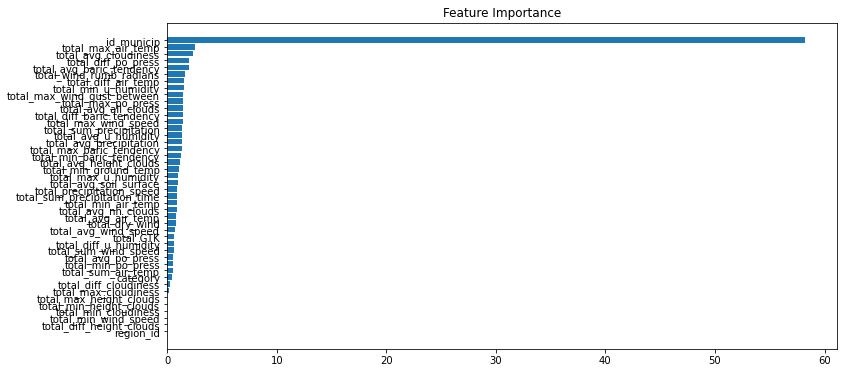

In [43]:
feature_importance = cat.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [51]:
train_data = Pool(data=train,
                  label= train_label)
                  #cat_features=category)

params = {"iterations": 3000,
          "loss_function": 'RMSE',
          "verbose": False}

scores = cv(train_data,
            params,
            fold_count=4, 
            plot="True",
            return_models=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/4]

bestTest = 2.87543154
bestIteration = 2999

Training on fold [1/4]

bestTest = 3.048826495
bestIteration = 2999

Training on fold [2/4]

bestTest = 2.92878459
bestIteration = 2999

Training on fold [3/4]

bestTest = 2.893779857
bestIteration = 2998



In [ ]:
model = CatBoostRegressor(iterations=3000, loss_function='RMSE', verbose=False) #, boosting_type='Ordered')

grid = {'depth': [4, 6, 10, 15],
        'l2_leaf_reg': [1, 3, 5, 7],
        'learning_rate': [0.025, 0.05, 0.075, 0.1],
        'max_leaves': [50, 64, 100]
       }

grid_result = model.grid_search(grid,
                                train_data,
                                cv=3,
                                plot=True)

In [52]:
model2 = CatBoostRegressor(iterations=5000, loss_function='RMSE', verbose=False) #, boosting_type='Ordered')
grid2 = {'depth': [5, 6, 7],
        'l2_leaf_reg': [0.75, 1, 1.25],
        'learning_rate': [0.04, 0.05, 0.06],
        'max_leaves': [63, 64, 65]
       }

grid_result2 = model2.grid_search(grid2,
                                train_data,
                                cv=3,
                                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 2.692027976
bestIteration = 4999

0:	loss: 2.6920280	best: 2.6920280 (0)	total: 1m 13s	remaining: 1h 37m 52s

bestTest = 2.659223726
bestIteration = 4993

1:	loss: 2.6592237	best: 2.6592237 (1)	total: 2m 30s	remaining: 1h 38m 50s

bestTest = 2.647996758
bestIteration = 4995

2:	loss: 2.6479968	best: 2.6479968 (2)	total: 3m 55s	remaining: 1h 42m 11s

bestTest = 2.698719143
bestIteration = 4998

3:	loss: 2.6987191	best: 2.6479968 (2)	total: 5m 8s	remaining: 1h 38m 55s

bestTest = 2.669828137
bestIteration = 4999

4:	loss: 2.6698281	best: 2.6479968 (2)	total: 6m 10s	remaining: 1h 33m 50s

bestTest = 2.638572496
bestIteration = 4998

5:	loss: 2.6385725	best: 2.6385725 (5)	total: 7m 17s	remaining: 1h 31m 13s

bestTest = 2.712172868
bestIteration = 4999

6:	loss: 2.7121729	best: 2.6385725 (5)	total: 8m 17s	remaining: 1h 27m 39s

bestTest = 2.6657743
bestIteration = 4985

7:	loss: 2.6657743	best: 2.6385725 (5)	total: 9m 24s	remaining: 1h 25m 49s

bestTest = 2.64854087
bestIteratio

In [58]:
#model2.get_all_params()
model2.get_best_score()

{'learn': {'RMSE': 1.8018286836639041}}

In [59]:
# CatBoost model prediction
cat_pred = model2.predict(test)
# RMSE Computation 
cat_rmse = mean_squared_error(test_label, cat_pred, squared=False)
print("CatBoost RMSE : % f" %(cat_rmse))

CatBoost RMSE :  4.063420


#### 2.2.3 Обучение модели XGBoost

In [44]:
# Обучение модели XGBoost
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror') #'reg:linear' - old called
xgb_reg.fit(X_train, y_train)

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
# RMSE Computation 
xgb_pred = xgb_reg.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_pred, squared=False)
print("XGBoost RMSE : % f" %(xgb_rmse))

XGBoost RMSE :  2.758183


In [46]:
xgb_pred = xgb_reg.predict(test)
# RMSE Computation 
xgb_rmse = mean_squared_error(test_label, xgb_pred, squared=False)
print("XGBoost RMSE : % f" %(xgb_rmse))

XGBoost RMSE :  4.119912


C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [48]:
importance = xgb_reg.feature_importances_
features = data.drop(columns=['year', 'meteoid', 'target'])
feature_importance = pd.DataFrame(zip(features,importance), columns=['features', 'importance'])
feature_importance = feature_importance.sort_values(by=['importance'], ascending=False)
feature_importance.head(50)

,features,importance
43,region_id,0.235928
42,id_municip,0.053321
28,total_sum_air_temp,0.050537
26,total_avg_soil_surface,0.045860
34,total_dry_wind,0.038957
29,total_sum_wind_speed,0.036515
17,total_avg_po_press,0.034423
20,total_avg_u_humidity,0.033444
35,total_diff_air_temp,0.028627
16,total_avg_air_temp,0.025561


Text(0.5, 1.0, 'Feature Importance')

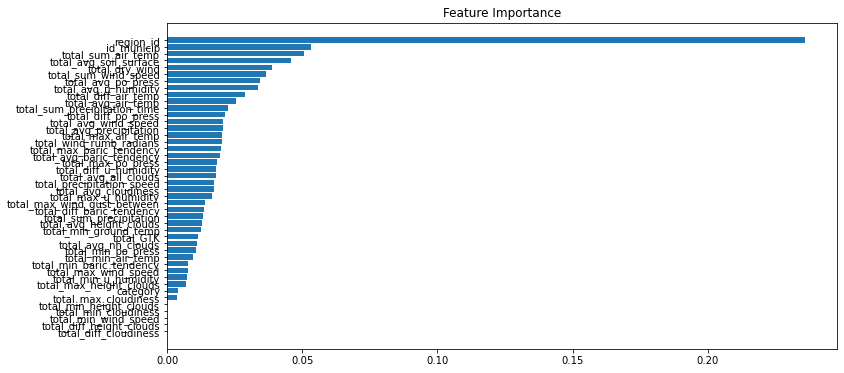

In [49]:
feature_importance = xgb_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
# Various hyper-parameters to tune
xgb_reg = xgb.XGBRegressor()
#xgb_reg = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0) #for GPU ver.
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.03, 0.05, 0.07],
              'max_depth': [5, 6, 7],
              'min_child_weight': [1, 2, 3, 4],
              'subsample': [0.5, 0.7, 1],
              'colsample_bytree': [0.5, 0.7, 1],
              'n_estimators': [500, 1000]}

xgb_grid = GridSearchCV(xgb_reg,
                        parameters,
                        cv = 3,
                        verbose=True) #n_jobs = -1,

xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

In [ ]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
def XGB_forecast(X, y, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:squarederror',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=5, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

In [ ]:
XGB_forecast(train, train_label, scale=1.96)